# Sentence Transformer

In [1]:
import copy
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_from_disk

import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

## GPU

In [2]:
!nvidia-smi

Mon Sep 18 23:16:08 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.99                 Driver Version: 536.99       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1070      WDDM  | 00000000:01:00.0  On |                  N/A |
| 29%   42C    P8              11W / 151W |   1766MiB /  8192MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Check if CUDA is available, else use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Hyperparameters

In [4]:
# Hyperparameters
LEARNING_RATE = 0.00001
BATCH_SIZE = 24
EPOCHS = 100

## Path

## Generate dataset and batch

In [5]:
class PromptDataset(Dataset):

    def __init__(self, dataset, device):
        self.dataset = dataset
        self.device = device

    def deserialize_array(self, binary_string, dtype, shape):
        return np.frombuffer(binary_string, dtype=dtype).reshape(shape)

    def __getitem__(self, index):
        data = self.dataset[index]
        # retrieve values
        student_id = data['student_id']
        prompt_id = data['prompt_id']
        embeddings_question = torch.tensor(self.deserialize_array(data['embeddings_question'], np.float32, (768,))).to(self.device)
        embeddings_text = torch.tensor(self.deserialize_array(data['embeddings_text'], np.float32, (768,))).to(self.device)
        text = torch.tensor(self.deserialize_array(data['text'], np.float32, (768,))).to(self.device)
        content = torch.tensor(data['content']).to(self.device)
        wording = torch.tensor(data['wording']).to(self.device)
        normalized_content = torch.tensor(data['normalized_content']).to(self.device)
        normalized_wording = torch.tensor(data['normalized_wording']).to(self.device)
        normalized_lexical_density = torch.tensor(data['normalized_lexical_density']).unsqueeze(0).to(self.device)
        normalized_spell_checker = torch.tensor(data['normalized_spell_checker']).unsqueeze(0).to(self.device)
        normalized_tf_idf_question_score = torch.tensor(data['normalized_tf_idf_question_score']).unsqueeze(0).to(self.device)
        normalized_avg_word_length = torch.tensor(data['normalized_avg_word_length']).unsqueeze(0).to(self.device)
        normalized_smog_index = torch.tensor(data['normalized_smog_index']).unsqueeze(0).to(self.device)
        normalized_coleman_liau_index = torch.tensor(data['normalized_coleman_liau_index']).unsqueeze(0).to(self.device)
        normalized_flesch_reading_ease = torch.tensor(data['normalized_flesch_reading_ease']).unsqueeze(0).to(self.device)
        
        return {
            'student_id': student_id,
            'prompt_id': prompt_id,
            'embeddings_question': embeddings_question,
            'embeddings_text': embeddings_text,
            'text': text,
            'content': content,
            'wording': wording,
            'normalized_content': normalized_content,
            'normalized_wording': normalized_wording,
            'normalized_lexical_density': normalized_lexical_density,
            'normalized_spell_checker': normalized_spell_checker,
            'normalized_tf_idf_question_score': normalized_tf_idf_question_score,
            'normalized_avg_word_length': normalized_avg_word_length,
            'normalized_smog_index': normalized_smog_index,
            'normalized_coleman_liau_index': normalized_coleman_liau_index,
            'normalized_flesch_reading_ease': normalized_flesch_reading_ease,
        }

    def __len__(self) -> int :
        return self.dataset.num_rows

In [6]:
class DataLoaderFactory():

    def __init__(self, path:str = './data/hugging_face', batch_size = 12, device = 'cpu'):
        self.batch_size = batch_size
        self.dataset = load_from_disk(path, keep_in_memory=True)
        self.device = device

        print("1. Loading dataset: ...", end="")
        dataset = load_from_disk(path, keep_in_memory=True)
        print("\r1. Loading dataset: done ✔️")

        print("2. Split datasets: ...", end="")
        train_validation_splits = self.dataset['train'].train_test_split(test_size=0.2)
        print("\r2. Preprocess datasets: done ✔️")

        print("3. Split datasets: ...", end="")
        self.train_data = PromptDataset(train_validation_splits['train'], self.device)
        self.val_data = PromptDataset(train_validation_splits['test'], self.device)
        print("\r3. Split datasets: done ✔️")

        self.dataloader_train = DataLoader(self.train_data, batch_size=batch_size, shuffle=True)
        self.dataloader_val = DataLoader(self.val_data, batch_size=batch_size, shuffle=True)
    
    
    def __len__(self) -> int :
        print("\033[95m\033[1m\033[4mNumber of data by datasets splits\033[0m")
        print(f"Train\t\t: {len(self.train_data)}\t-> {len(self.train_data)/self.batch_size}")
        print(f"Validation\t: {len(self.val_data)}\t\t-> {len(self.val_data)/self.batch_size}")
        total = len(self.train_data) + len(self.val_data)
        print(f"Total\t\t: {total}")
        return total

    def get_batch(self, split):
        # choose the correct dataloader
        if split == 'train':
            dataloader = self.dataloader_train
        else:
            dataloader = self.dataloader_val

        for batch in dataloader:
            # Move tensors to device
            batch_on_device = {k: v for k, v in batch.items()}
            yield batch_on_device

### Load the dataset

In [7]:
dataset = DataLoaderFactory(device=device, batch_size=BATCH_SIZE)
len(dataset)

1. Loading dataset: done ✔️
2. Preprocess datasets: done ✔️
3. Split datasets: done ✔️
Number of data by datasets splits
Train		: 5732	-> 238.83333333333334
Validation	: 1433		-> 59.708333333333336
Total		: 7165


7165

### Testing the dataset

In [8]:
batch = dataset.get_batch('train')
nb = next(batch)

In [9]:
print(f"{'student_id:':<25}{len(nb['student_id'])}")
print(f"{'prompt_id:':<25}{len(nb['prompt_id'])}")
print(f"{'embeddings_question:':<25}{nb['embeddings_question'].shape}")
print(f"{'embeddings_text:':<25}{nb['embeddings_text'].shape}")
print(f"{'text:':<25}{nb['text'].shape}")
print(f"{'content:':<25}{nb['content'].shape}")
print(f"{'wording:':<25}{nb['wording'].shape}")
print(f"{'normalized_content:':<25}{nb['normalized_content'].shape}")
print(f"{'normalized_wording:':<25}{nb['normalized_wording'].shape}")
print(f"{'normalized_lexical_density:':<25}{nb['normalized_lexical_density'].shape}")
print(f"{'normalized_spell_checker:':<25}{nb['normalized_spell_checker'].shape}")
print(f"{'normalized_tf_idf_question_score:':<25}{nb['normalized_tf_idf_question_score'].shape}")
print(f"{'normalized_avg_word_length:':<25}{nb['normalized_avg_word_length'].shape}")
print(f"{'normalized_smog_index:':<25}{nb['normalized_smog_index'].shape}")
print(f"{'normalized_coleman_liau_index:':<25}{nb['normalized_coleman_liau_index'].shape}")
print(f"{'normalized_flesch_reading_ease:':<25}{nb['normalized_flesch_reading_ease'].shape}")

student_id:              24
prompt_id:               24
embeddings_question:     torch.Size([24, 768])
embeddings_text:         torch.Size([24, 768])
text:                    torch.Size([24, 768])
content:                 torch.Size([24])
wording:                 torch.Size([24])
normalized_content:      torch.Size([24])
normalized_wording:      torch.Size([24])
normalized_lexical_density:torch.Size([24, 1])
normalized_spell_checker:torch.Size([24, 1])
normalized_tf_idf_question_score:torch.Size([24, 1])
normalized_avg_word_length:torch.Size([24, 1])
normalized_smog_index:   torch.Size([24, 1])
normalized_coleman_liau_index:torch.Size([24, 1])
normalized_flesch_reading_ease:torch.Size([24, 1])


## Training model

1. **Input Layer:** Accept the embeddings of the question, text, and answer. This would result in three separate input layers, each of dimension `[batch_size, embedding_size]`.
2. **Concatenate Layer:** Concatenate the embeddings along the feature axis. This results in `[batch_size, 3 * embedding_size]` dimensions.
3. **Dense Layers:** Add a couple of Dense layers with suitable dropout layers in between for regularization. For instance:
    - Dense layer with `1024` units, `ReLU` activation.
    - Dropout layer with rate `0.5`.
    - Dense layer with `512` units, ReLU activation.
    - Another Dropout layer with rate `0.5`.
4. **Output Layer:** Single Dense layer with `2` units (since you want two values between -1 and 1) and a `tanh` activation function.
5. **Loss Function:** If the output of your model is a vector with two values between -1 and 1, then you're essentially dealing with multi-output regression. You can use `Mean Squared Error` or `Mean Absolute Error`, but it'll be applied to each output.
6. **Optimizer:** Remains the same; options include `Adam`, `RMSprop`, and `SGD`.

### Define the Model

In [10]:
# # Define the Model
# class QA_Score_Model(nn.Module):
#     def __init__(self, input_dim=3*768+7, dropout_rate=0.5):
#         super(QA_Score_Model, self).__init__()

#         # Dense Layers
#         self.fc1 = nn.Linear(input_dim, 1024)
#         self.fc2 = nn.Linear(1024, 512)
#         self.fc3 = nn.Linear(512, 2)  # Output 2 values for each instance

#         # Dropout
#         self.dropout = nn.Dropout(dropout_rate)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         if self.training:
#             x = self.dropout(x)
#         x = F.relu(self.fc2(x))
#         if self.training:
#             x = self.dropout(x)
#         x = torch.tanh(self.fc3(x))  # tanh to get outputs in range [-1, 1]
#         return x

In [11]:
class QA_Score_Model(nn.Module):
    def __init__(self, embedding_dim, dropout_rate=0.5):
        super(QA_Score_Model, self).__init__()

        # Embedding processors
        self.fc_text = nn.Linear(embedding_dim, 256)
        self.fc_question = nn.Linear(embedding_dim, 256)
        self.fc_answer = nn.Linear(embedding_dim, 256)

        # Scalar Processors
        self.fc_lexical = nn.Linear(1, 16)
        self.fc_spell = nn.Linear(1, 16)
        self.fc_tfidf = nn.Linear(1, 16)
        self.fc_avg_word_length = nn.Linear(1, 16)
        self.fc_smog = nn.Linear(1, 16)
        self.fc_coleman = nn.Linear(1, 16)
        self.fc_flesch = nn.Linear(1, 16)

        # Dropout layers
        self.dropout = nn.Dropout(dropout_rate)

        # Shared Dense Layers
        self.fc1 = nn.Linear(256*3 + 16*7, 512)
        self.fc2 = nn.Linear(512, 256)
        
        # Output Layers
        self.out_content = nn.Linear(256, 1)
        self.out_wording = nn.Linear(256, 1)
        
    def forward(self, text, question, answer, features):
        lexical, spell, tfidf, avg_word_length, smog, coleman, flesch = features
        # Pass through convolutional layers
        x_text = F.relu(self.fc_text(text))
        x_question = F.relu(self.fc_question(question))
        x_answer = F.relu(self.fc_answer(answer))

        # Pass through scalar processors
        x_lexical = F.relu(self.fc_lexical(lexical))
        x_spell = F.relu(self.fc_spell(spell))
        x_tfidf = F.relu(self.fc_tfidf(tfidf))
        x_avg_word_length = F.relu(self.fc_avg_word_length(avg_word_length))
        x_smog = F.relu(self.fc_smog(smog))
        x_coleman = F.relu(self.fc_coleman(coleman))
        x_flesch = F.relu(self.fc_flesch(flesch))
        
        # Concatenate
        x = torch.cat((x_text, x_question, x_answer, x_lexical, x_spell, x_tfidf, x_avg_word_length, x_smog, x_coleman, x_flesch), dim=1)
        
        # Pass through shared dense layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        # Output
        content = self.out_content(x)
        wording = self.out_wording(x)
        
        return torch.cat((content, wording), dim=1).to(device)

### Create an instance of the model, loss function and the optimizer

In [12]:
# Create an instance of the model, loss function and the optimizer
model = QA_Score_Model(768)
model = model.to(device)
criterion = nn.L1Loss()  # Mean Absolute Error less sensitive to outliers # MSELoss Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### MCRMSE loss

In [13]:
def MCRMSE(targets, predictions):
    """
    Compute the Mean Columnwise Root Mean Squared Error.
    
    Parameters:
    - targets: Actual target values
    - predictions: Model's predictions
    
    Returns:
    - Mean Columnwise RMSE
    """
    # Compute squared error
    mse = torch.mean((targets - predictions) ** 2, dim=0)
    
    # Take square root of each column's MSE
    rmse = torch.sqrt(mse)
    
    # Compute mean of RMSE across all columns
    mcrmse = torch.mean(rmse)
    
    return mcrmse

### Training loop

In [14]:
def training_loop(model, dataset, epoch):
    model = model.train()
    
    total_train_loss = 0.0
    total_train_mcrmse = 0.0
    
    batchs = dataset.get_batch('train')
    
    num_train_batches = len(dataset.train_data) // BATCH_SIZE
    for i, batch in enumerate(batchs):
        # Get the batch data
        student_id = batch['student_id']
        prompt_id = batch['prompt_id']
        embeddings_question = batch['embeddings_question']
        embeddings_text = batch['embeddings_text']
        embeddings_answer = batch['text']
        content = batch['content']
        wording = batch['wording']
        normalized_content = batch['normalized_content']
        normalized_wording = batch['normalized_wording']
        normalized_lexical_density = batch['normalized_lexical_density']
        normalized_spell_checker = batch['normalized_spell_checker']
        normalized_tf_idf_question_score = batch['normalized_tf_idf_question_score']
        normalized_avg_word_length = batch['normalized_avg_word_length']
        normalized_smog_index = batch['normalized_smog_index']
        normalized_coleman_liau_index = batch['normalized_coleman_liau_index']
        normalized_flesch_reading_ease = batch['normalized_flesch_reading_ease']
        
        # create input targets
        # input_data = torch.cat(
        #     (
        #         embeddings_question,
        #         embeddings_text,
        #         embeddings_text,
        #         normalized_lexical_density,
        #         normalized_spell_checker,
        #         normalized_tf_idf_question_score,
        #         normalized_avg_word_length,
        #         normalized_smog_index,
        #         normalized_coleman_liau_index,
        #         normalized_flesch_reading_ease
        #     ), dim=1).to(device)
        targets = torch.stack(
            (
                normalized_content,
                normalized_wording
            ), dim=1).to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        features = (normalized_lexical_density, \
                    normalized_spell_checker, \
                    normalized_tf_idf_question_score, \
                    normalized_avg_word_length, \
                    normalized_smog_index, \
                    normalized_coleman_liau_index, \
                    normalized_flesch_reading_ease \
                   )
        outputs = model(embeddings_text, embeddings_question, embeddings_answer, features)

        # Loss
        loss = criterion(outputs, targets)
        eval_metric = MCRMSE(targets, outputs)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print loss (you might want to print every N batches, not every batch)
        print(f"\rEpoch [{epoch + 1}/{EPOCHS}], Batch [{i}/{num_train_batches}], Loss: {loss.item()}, MCRMSE: {eval_metric.item()}", end="")
        

        total_train_loss += loss.item()
        total_train_mcrmse += eval_metric.item()

    avg_train_loss = total_train_loss / num_train_batches
    avg_train_mcrmse = total_train_mcrmse / num_train_batches

    return model, avg_train_loss, avg_train_mcrmse

### Validation loop

In [15]:
def validation_loop(model, dataset, epoch):
    print(f"\nValidating...", end="")
    # Validation Evaluation
    model = model.eval()  # Set the model to evaluation mode
    
    total_val_loss = 0.0
    total_val_mcrmse = 0.0
    
    val_batches = dataset.get_batch('val')
    
    num_val_batches = len(dataset.val_data) // BATCH_SIZE
    with torch.no_grad():  # Disable gradient computations
        for i, val_batch in enumerate(val_batches):
            student_id = val_batch['student_id']
            prompt_id = val_batch['prompt_id']
            embeddings_question = val_batch['embeddings_question']
            embeddings_text = val_batch['embeddings_text']
            embeddings_answer = val_batch['text']
            content = val_batch['content']
            wording = val_batch['wording']
            normalized_content = val_batch['normalized_content']
            normalized_wording = val_batch['normalized_wording']
            normalized_lexical_density = val_batch['normalized_lexical_density']
            normalized_spell_checker = val_batch['normalized_spell_checker']
            normalized_tf_idf_question_score = val_batch['normalized_tf_idf_question_score']
            normalized_avg_word_length = val_batch['normalized_avg_word_length']
            normalized_smog_index = val_batch['normalized_smog_index']
            normalized_coleman_liau_index = val_batch['normalized_coleman_liau_index']
            normalized_flesch_reading_ease = val_batch['normalized_flesch_reading_ease']

            # Create input and targets
            # val_input_data = torch.cat(
            #     (
            #         embeddings_question,
            #         embeddings_question,
            #         text,
            #         normalized_lexical_density,
            #         normalized_spell_checker,
            #         normalized_tf_idf_question_score,
            #         normalized_avg_word_length,
            #         normalized_smog_index,
            #         normalized_coleman_liau_index,
            #         normalized_flesch_reading_ease
            #     ), dim=1).to(device)
            val_targets = torch.stack((normalized_content, normalized_wording), dim=1).to(device)
            
            features = (normalized_lexical_density, \
                        normalized_spell_checker, \
                        normalized_tf_idf_question_score, \
                        normalized_avg_word_length, \
                        normalized_smog_index, \
                        normalized_coleman_liau_index, \
                        normalized_flesch_reading_ease \
                       )
            # Forward pass
            val_outputs = model(embeddings_text, embeddings_question, embeddings_answer, features)

            # Compute loss and MCRMSE
            val_loss = criterion(val_outputs, val_targets)
            val_mcrmse = MCRMSE(val_targets, val_outputs)

            total_val_loss += val_loss.item()
            total_val_mcrmse += val_mcrmse.item()

    avg_val_loss = total_val_loss / num_val_batches
    avg_val_mcrmse = total_val_mcrmse / num_val_batches

    print(f"\rValidation Loss after Epoch {epoch + 1}: {avg_val_loss}, Avg MCRMSE: {avg_val_mcrmse}\n")
    
    return avg_val_loss, avg_val_mcrmse

In [16]:
# Early stopping parameters
patience = 5  # Number of epochs with no improvement after which training will be stopped
counter = 0  # To count number of epochs with no improvement
best_val_loss = None  # To keep track of best validation loss
best_model_state = None  # To store best model's state

train_losses = []
train_mcrmse = []
val_losses = []
val_mcrmse = []

for epoch in range(EPOCHS):
    # training loop
    model, epoch_train_loss, epoch_train_mcrmse = training_loop(model, dataset, epoch)
    train_losses.append(epoch_train_loss)
    train_mcrmse.append(epoch_train_mcrmse)
    
    # validation loop
    epoch_val_loss, epoch_val_mcrmse = validation_loop(model, dataset, epoch)
    val_losses.append(epoch_val_loss)
    val_mcrmse.append(epoch_val_mcrmse)

    # Check if this epoch's validation loss is the best we've seen so far.
    if best_val_loss is None or epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = copy.deepcopy(model.state_dict())  # Save best model
        counter = 0  # Reset counter
    else:
        counter += 1  # Increment counter as no improvement in validation loss

    # If we've had patience number of epochs without improvement, stop training
    if counter >= patience:
        print(f"Early stopping on epoch {epoch}. Best epoch was {epoch - counter} with val loss: {best_val_loss:.4f}.")
        break

# Load best model weights
model.load_state_dict(best_model_state)
torch.save(model.state_dict(), './out/best_model.pt')  # Save the best model to disk

Epoch [1/100], Batch [238/238], Loss: 0.2598763406276703, MCRMSE: 0.316794514656066937
Validation Loss after Epoch 1: 0.28345261387905835, Avg MCRMSE: 0.3550903787047176

Epoch [2/100], Batch [238/238], Loss: 0.2856657803058624, MCRMSE: 0.339859575033187877
Validation Loss after Epoch 2: 0.27154745136277153, Avg MCRMSE: 0.34461539857468365

Epoch [3/100], Batch [238/238], Loss: 0.2767011821269989, MCRMSE: 0.358712077140808166
Validation Loss after Epoch 3: 0.2636886140552618, Avg MCRMSE: 0.3356227261030068

Epoch [4/100], Batch [238/238], Loss: 0.24908733367919922, MCRMSE: 0.33795413374900825
Validation Loss after Epoch 4: 0.2550648397813409, Avg MCRMSE: 0.32379134327678355

Epoch [5/100], Batch [238/238], Loss: 0.19935958087444305, MCRMSE: 0.26316758990287785
Validation Loss after Epoch 5: 0.2443442180500192, Avg MCRMSE: 0.3109513048903417

Epoch [6/100], Batch [238/238], Loss: 0.22070729732513428, MCRMSE: 0.26165780425071716
Validation Loss after Epoch 6: 0.23103827389620119, Avg MCR

### Loss visualization

In [17]:
def plot_graphs(train_losses, val_losses, train_mcrmse, val_mcrmse):
    # Monokai color palette
    colors = ['#F92672', '#A6E22E', '#66D9EF', '#FD971F']
    
    # Set the background color and grid color
    sns.set_style("darkgrid", {
        "axes.facecolor": ".1",  # Dark background
        "grid.color": ".15",  # Slightly grayish grid lines
        "axes.labelcolor": "white",
        "xtick.color": "white",
        "ytick.color": "white"
    })

    epochs = range(1, len(train_losses) + 1)

    # Plotting the losses
    plt.figure(figsize=(12, 6))

    # Set entire background color
    fig = plt.gcf()
    fig.patch.set_facecolor('.1')  # Color for the whole backgroun

    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs, y=train_losses, label='Train Loss', marker='o', color=colors[0])
    sns.lineplot(x=epochs, y=val_losses, label='Validation Loss', marker='o', color=colors[1])
    plt.title('Training and Validation Loss', color='white')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    legend = plt.legend()
    for text in legend.get_texts():
        text.set_color("white")  # Set the legend text color to white

    # Plotting the MCRMSE
    plt.subplot(1, 2, 2)
    sns.lineplot(x=epochs, y=train_mcrmse, label='Train MCRMSE', marker='o', color=colors[2])
    sns.lineplot(x=epochs, y=val_mcrmse, label='Validation MCRMSE', marker='o', color=colors[3])
    plt.title('Training and Validation MCRMSE', color='white')
    plt.xlabel('Epochs')
    plt.ylabel('MCRMSE')
    legend = plt.legend()
    for text in legend.get_texts():
        text.set_color("white")  # Set the legend text color to white

    plt.tight_layout()
    plt.show()

C:\Users\thiba\.virtualenvs\commonlit-evaluate-student-summaries-bVvbF_GV\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\thiba\.virtualenvs\commonlit-evaluate-student-summaries-bVvbF_GV\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\thiba\.virtualenvs\commonlit-evaluate-student-summaries-bVvbF_GV\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\thiba\.virtualenvs\commonlit-evaluate-student-summaries-bVvbF_GV\L

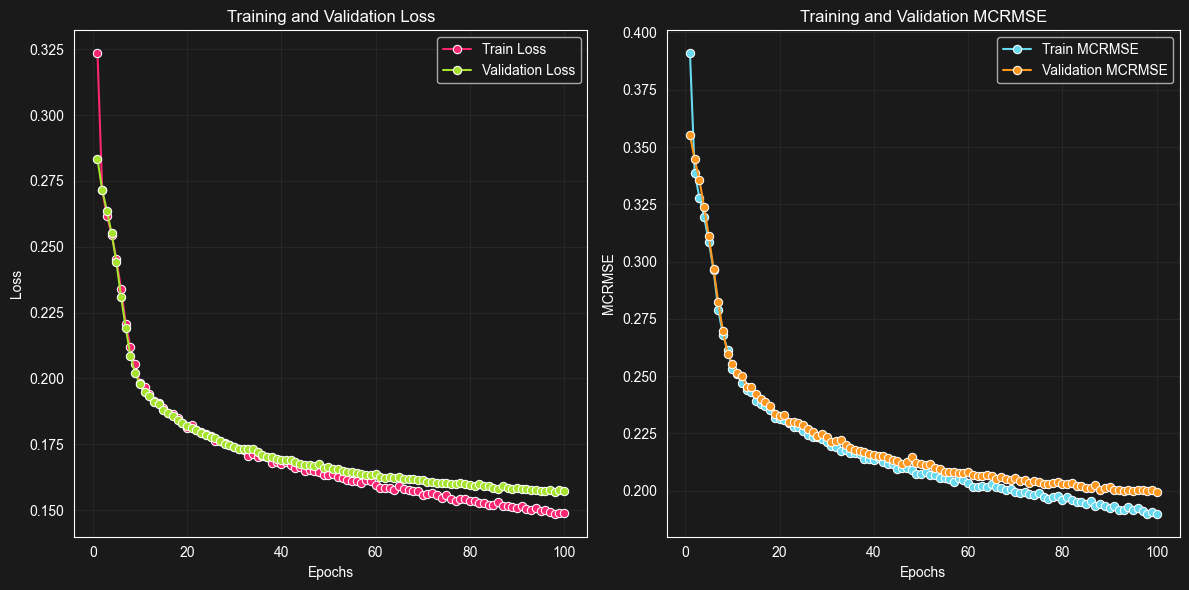

In [18]:
# After training, call the function to plot
plot_graphs(train_losses, val_losses, train_mcrmse, val_mcrmse)

## Saving torch script

In [19]:
model.load_state_dict(torch.load('./out/best_model.pt'))

<All keys matched successfully>

In [25]:
exemple_batches = dataset.get_batch('train')
ex_batch = next(exemple_batches)
embeddings_question = ex_batch['embeddings_question']
embeddings_text = ex_batch['embeddings_text']
embeddings_answer = ex_batch['text']
normalized_content = ex_batch['normalized_content']
normalized_wording = ex_batch['normalized_wording']
normalized_lexical_density = ex_batch['normalized_lexical_density']
normalized_spell_checker = ex_batch['normalized_spell_checker']
normalized_tf_idf_question_score = ex_batch['normalized_tf_idf_question_score']
normalized_avg_word_length = ex_batch['normalized_avg_word_length']
normalized_smog_index = ex_batch['normalized_smog_index']
normalized_coleman_liau_index = ex_batch['normalized_coleman_liau_index']
normalized_flesch_reading_ease = ex_batch['normalized_flesch_reading_ease']
# example_input_tensor = torch.cat(
#     (
#         embeddings_question,
#         embeddings_text,
#         text,
#         normalized_lexical_density,
#         normalized_spell_checker,
#         normalized_tf_idf_question_score,
#         normalized_avg_word_length,
#         normalized_smog_index,
#         normalized_coleman_liau_index,
#         normalized_flesch_reading_ease
#     ), dim=1)

features = (normalized_lexical_density.to('cpu'), \
            normalized_spell_checker.to('cpu'), \
            normalized_tf_idf_question_score.to('cpu'), \
            normalized_avg_word_length.to('cpu'), \
            normalized_smog_index.to('cpu'), \
            normalized_coleman_liau_index.to('cpu'), \
            normalized_flesch_reading_ease.to('cpu') \
           )

In [27]:
# Trace the model
traced_model = torch.jit.trace(model.to('cpu'), (embeddings_text.to('cpu'), embeddings_question.to('cpu'), embeddings_answer.to('cpu'), features))
# Save the traced model
traced_model.save("./out/best_model_script.pt")

In [28]:
import math

In [29]:
def t_round(x, decimals = 3):
    multiplicator = 10**decimals
    return torch.round(x * 1000) / 1000

In [31]:
tensor1, tensor2 = model(embeddings_text.to('cpu'), embeddings_question.to('cpu'), embeddings_answer.to('cpu'), features), torch.stack((normalized_content, normalized_wording), dim=1)


for (col1_tensor1, col2_tensor1), (col1_tensor2, col2_tensor2) in zip(tensor1, tensor2):
    print(f"[{col1_tensor1:>6.3f} => {col1_tensor2:>6.3f} = {col1_tensor2-col1_tensor1:>6.3f}] \t | \t [{col2_tensor1:>6.3f} => {col2_tensor2:>6.3f} = {col2_tensor2 - col2_tensor1:>6.3f}]")

[-0.553 => -0.755 = -0.202] 	 | 	 [-0.481 => -0.835 = -0.354]
[-0.550 => -0.543 =  0.007] 	 | 	 [-0.584 => -0.375 =  0.208]
[-0.735 => -0.694 =  0.041] 	 | 	 [-0.513 => -0.388 =  0.125]
[-0.579 => -0.363 =  0.216] 	 | 	 [-0.560 => -0.569 = -0.010]
[-0.320 => -0.365 = -0.045] 	 | 	 [-0.275 => -0.165 =  0.109]
[-0.242 => -0.304 = -0.061] 	 | 	 [-0.258 => -0.532 = -0.274]
[-0.432 => -0.426 =  0.006] 	 | 	 [-0.466 => -0.612 = -0.146]
[ 0.133 => -0.265 = -0.398] 	 | 	 [ 0.087 => -0.206 = -0.294]
[-0.619 => -0.657 = -0.038] 	 | 	 [-0.557 => -0.472 =  0.085]
[-0.583 => -0.580 =  0.003] 	 | 	 [-0.526 => -0.333 =  0.194]
[ 0.407 =>  0.631 =  0.224] 	 | 	 [ 0.297 =>  0.840 =  0.543]
[-0.425 => -0.606 = -0.181] 	 | 	 [-0.516 => -0.544 = -0.028]
[ 0.113 =>  0.184 =  0.071] 	 | 	 [ 0.046 => -0.169 = -0.215]
[-0.296 => -0.204 =  0.092] 	 | 	 [-0.453 => -0.573 = -0.120]
[-0.713 => -0.765 = -0.053] 	 | 	 [-0.709 => -0.540 =  0.169]
[-0.091 =>  0.064 =  0.156] 	 | 	 [-0.077 =>  0.016 =  0.093]
[-0.378 

In [ ]:
# [-0.418 => -0.234 =  0.184] 	 | 	 [-0.422 => -0.390 =  0.032]
# [-0.261 => -0.114 =  0.147] 	 | 	 [-0.298 => -0.193 =  0.105]
# [-0.543 => -0.621 = -0.078] 	 | 	 [-0.391 => -0.668 = -0.277]
# [-0.205 => -0.204 =  0.001] 	 | 	 [-0.242 => -0.573 = -0.331]
# [-0.383 => -0.285 =  0.098] 	 | 	 [-0.383 => -0.318 =  0.065]
# [ 0.008 =>  0.095 =  0.087] 	 | 	 [-0.194 => -0.167 =  0.027]
# [-0.041 =>  0.257 =  0.298] 	 | 	 [-0.188 => -0.151 =  0.037]
# [-0.130 => -0.187 = -0.057] 	 | 	 [-0.060 =>  0.044 =  0.104]
# [-0.370 => -0.464 = -0.094] 	 | 	 [-0.374 => -0.640 = -0.266]
# [-0.434 =>  0.341 =  0.775] 	 | 	 [-0.396 => -0.182 =  0.214]
# [-0.757 => -0.849 = -0.092] 	 | 	 [-0.694 => -0.820 = -0.126]
# [ 0.091 =>  0.250 =  0.159] 	 | 	 [ 0.057 =>  0.265 =  0.208]

## Load the Traced Model

In [32]:
loaded_model = torch.jit.load("./out/best_model_script.pt").to(device)

In [36]:
features = (normalized_lexical_density.to(device), \
            normalized_spell_checker.to(device), \
            normalized_tf_idf_question_score.to(device), \
            normalized_avg_word_length.to(device), \
            normalized_smog_index.to(device), \
            normalized_coleman_liau_index.to(device), \
            normalized_flesch_reading_ease.to(device) \
           )

In [37]:
loaded_model(embeddings_text.to(device), embeddings_question.to(device), embeddings_answer.to(device), features)

tensor([[-0.5532, -0.4810],
        [-0.5499, -0.5836],
        [-0.7345, -0.5132],
        [-0.5785, -0.5596],
        [-0.3200, -0.2748],
        [-0.2423, -0.2579],
        [-0.4320, -0.4661],
        [ 0.1334,  0.0871],
        [-0.6189, -0.5570],
        [-0.5827, -0.5264],
        [ 0.4068,  0.2972],
        [-0.4250, -0.5157],
        [ 0.1128,  0.0463],
        [-0.2956, -0.4527],
        [-0.7127, -0.7087],
        [-0.0915, -0.0765],
        [-0.3782, -0.2336],
        [-0.6063, -0.7075],
        [-0.2091, -0.4089],
        [-0.2001, -0.4268],
        [-0.3521, -0.2885],
        [-0.2385, -0.3476],
        [-0.6328, -0.6093],
        [-0.1332, -0.0215]], device='cuda:0', grad_fn=<CatBackward0>)

In [ ]:
assert 'a' == 'b'

## export sentence transformer

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

In [ ]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [ ]:
# Sentences we want sentence embeddings for
sentences = ['This is an example sentence', 'Each sentence is converted']

In [ ]:
# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

In [ ]:
# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

In [ ]:
# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

In [ ]:
# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

In [ ]:
# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)


In [ ]:
print("Sentence embeddings:")
print(sentence_embeddings.shape)

In [ ]:
class SentenceTransformer(torch.nn.Module):
    def __init__(self, repo):
        super(SentenceTransformer, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(repo)
        self.model = AutoModel.from_pretrained(repo)

    #Mean Pooling - Take attention mask into account for correct averaging
    def _mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def encode(self, sentences):
        # Tokenize sentences
        encoded_input = self.tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
        # Compute token embeddings
        with torch.no_grad():
            model_output = self.model(**encoded_input)
        # Perform pooling
        sentence_embeddings = self._mean_pooling(model_output, encoded_input['attention_mask'])
        # Normalize embeddings
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        return sentence_embeddings

In [ ]:
sentence_transformer = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [ ]:
embeddings = sentence_transformer.encode(sentences)

In [ ]:
embeddings.shape